In [1]:
from posteriordb import PosteriorDatabase

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jax import random, vmap, jit
import jax.numpy as jnp
import jax

import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
from numpyro.infer.inspect import render_model
from numpyro.diagnostics import hpdi

from AMH import *
from evaluation import wasserstein_1d, wasserstein_dist11_p, wasserstein_sinkhorn_unbiased, max_sliced_wasserstein

# 1. Univariate distribution

In [2]:
mixing_dist = dist.Categorical(probs=jnp.array([1/3, 2/3]))
component_dist = dist.Normal(loc=jnp.array([-5, 5]), scale=jnp.array([1, 1]))
mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

potential_fn = lambda x: -1 *mixture.log_prob(x)

In [3]:
kernel = AMH(potential_fn=potential_fn)

## 1.1. Sampling adaptive states

In [4]:
k1, k2 = random.split(random.PRNGKey(0))
s1 = sample_adapt_state(k1)
s2 = sample_neigbour(k2, s1, eps=0.01)

sample_dist1 = dist.MultivariateNormal(loc=s1.mean, covariance_matrix=jnp.exp(s1.log_step_size)*s1.covariance)
sample_dist2 = dist.MultivariateNormal(loc=s2.mean, covariance_matrix=jnp.exp(s2.log_step_size)*s2.covariance)

state_dist(s1, s2)

Array(0.24729204, dtype=float32)

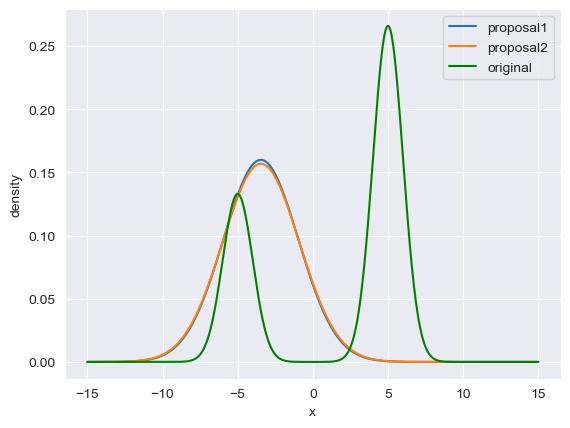

In [5]:
x_dist = jnp.arange(-15, 15, .002)
# plt.hist(mcmc.get_samples(), bins=50, density=True, label="samples")
plt.plot(x_dist, jnp.exp(vmap(sample_dist1.log_prob)(x_dist)), label="proposal1")
plt.plot(x_dist, jnp.exp(vmap(sample_dist2.log_prob)(x_dist)), label="proposal2")
plt.plot(x_dist, jnp.exp(mixture.log_prob(x_dist)), color="green", label="original")

plt.ylabel("density")
plt.xlabel("x")
plt.legend()

## 1.2. Sampling from $P(x, \cdot)$

In [6]:
%%time 

x = jnp.arange(-10, 10, 0.01)
N = 1000

k1, k2 = random.split(random.PRNGKey(0))

P1x = sample_Px(k1, kernel, x, s1, N)
P2x = sample_Px(k2, kernel, x, s2, N)

CPU times: user 11.1 s, sys: 19.1 s, total: 30.2 s
Wall time: 11.3 s


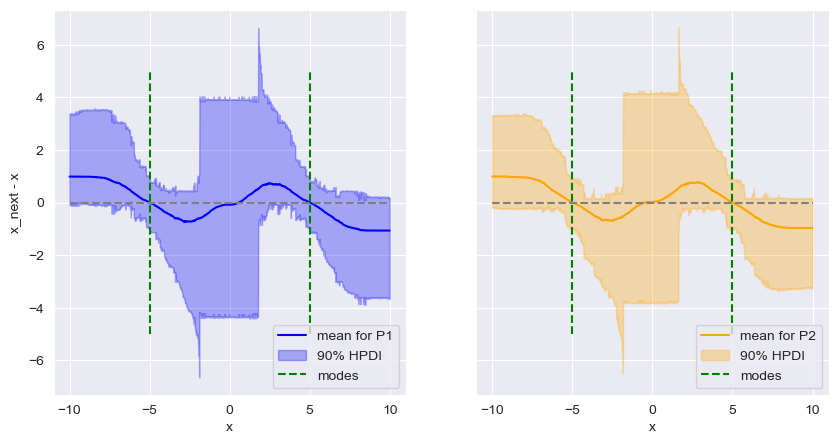

In [7]:
dP1x_mean = P1x.mean(axis=0) - x
P1x_hdpi = hpdi(P1x, prob=0.9) - x
dP2x_mean = P2x.mean(axis=0) - x
P2x_hdpi = hpdi(P2x, prob=0.9) - x

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax1.plot(x, dP1x_mean, color='blue', label="mean for P1")
ax2.plot(x, dP2x_mean, color='orange', label="mean for P2")
ax1.fill_between(x, *P1x_hdpi, alpha=0.3, color="blue", label="90% HPDI")
ax2.fill_between(x, *P2x_hdpi, alpha=0.3, color="orange", label="90% HPDI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
ax1.hlines(0, -10, 10, linestyles='--', color="gray")
ax2.hlines(0, -10, 10, linestyles='--', color="gray")
ax1.vlines([-5, 5], -5, 5, linestyles='--', color="green", label="modes")
ax2.vlines([-5, 5], -5, 5, linestyles='--', color="green", label="modes")
ax1.set_ylabel("x_next - x")
ax1.set_xlabel("x")
ax2.set_xlabel("x")
ax1.legend(loc="lower right")
ax2.legend(loc="lower right")

## 1.3. Invariance Property

In [8]:
%%time

k1, k2, ks = random.split(random.PRNGKey(0), 3)
dist_samples = mixture.sample(ks, sample_shape=(1000,))

P1pi = sample_Px(k1, kernel, dist_samples, s1, n_samples=1000).flatten()
P2pi = sample_Px(k2, kernel, dist_samples, s2, n_samples=1000).flatten()

CPU times: user 3.34 s, sys: 4.53 s, total: 7.87 s
Wall time: 3.13 s


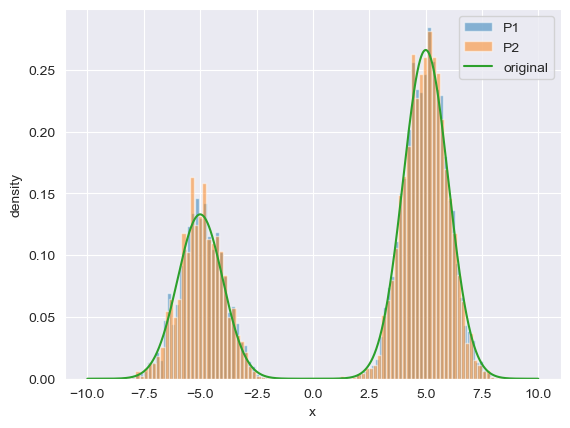

In [9]:
plt.hist(P1pi, bins=100, density=True, alpha=0.5, label="P1")
plt.hist(P2pi, bins=100, density=True, alpha=0.5, label="P2")
plt.plot(x, jnp.exp(mixture.log_prob(x)), label="original")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()

## 1.4. Contraction Property

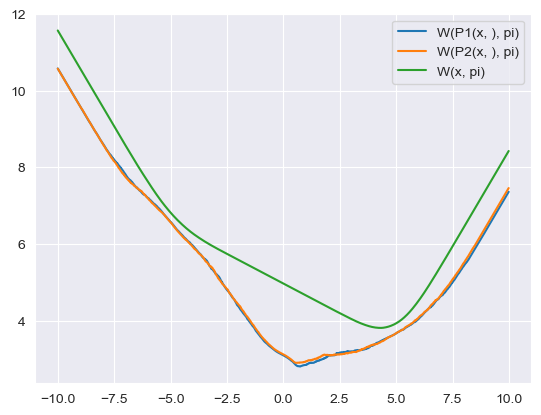

In [10]:
W_P1xpi = wasserstein_1d(dist_samples[None, :N], P1x.T)
W_P2xpi = wasserstein_1d(dist_samples[None, :N], P2x.T)
E_x = wasserstein_1d(dist_samples[None, :], x[:, None])

plt.plot(x, W_P1xpi, label="W(P1(x, ), pi)")
plt.plot(x, W_P2xpi, label="W(P2(x, ), pi)")
plt.plot(x, E_x, label="W(x, pi)")
plt.legend()

# Lipschitz Property

In [11]:
def sample_lipschitz_func(rng_key, domain=(-10, 10), step=0.1):
    """
    Generates a random 1-Lipschitz finction with given domain and grid size
    """
    points = jnp.arange(*domain, step)
    N, = points.shape

    u = dist.Uniform(-1, 1).sample(rng_key, sample_shape=(N,))
    u -= u.mean()
    u /= jnp.max(jnp.abs(u))
    
    values = jnp.tri(N,N) @ u * step
        
    return jax.scipy.interpolate.RegularGridInterpolator((points,), values, fill_value=0)

In [12]:
# func = sample_lipschitz_func(random.PRNGKey(0), domain=(-10, 10), step=0.1)
# 
# P1fx = vmap(func)(P1x).mean(axis=0)
# P2fx = vmap(func)(P2x).mean(axis=0)
# 
# jnp.abs(jnp.diff(func(x))/jnp.diff(x)).max()

Array(0.9995412, dtype=float32)

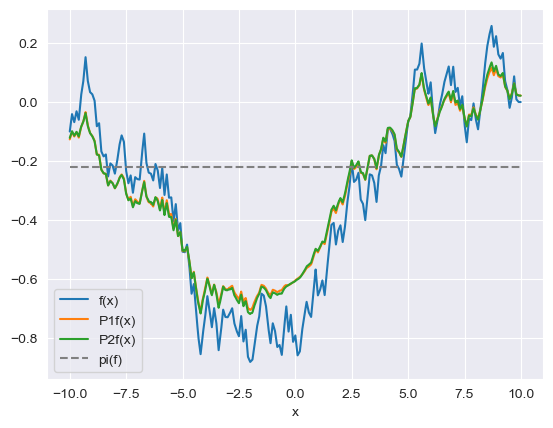

In [13]:
# plt.plot(x, func(x), label="f(x)")
# plt.plot(x, P1fx, label="P1f(x)")
# plt.plot(x, P2fx, label="P2f(x)")
# # plt.plot(x, jnp.abs(P1fx-P2fx), label="diff")
# plt.hlines(func(dist_samples).mean(), x.min(), x.max(), linestyles="--", color="gray", label="pi(f)")
# plt.xlabel("x")
# plt.legend()

In [14]:
# diff = P1fx - P2fx
# 
# diff_norm = jnp.abs(jnp.diff(diff)/jnp.diff(x)).max()
# diff_norm

Array(0.2499106, dtype=float32)

In [15]:
def compute_lipschitz(rng_key, kernel, eps=0.001, domain=(-10, 10), step=0.01, n_samples=500):

    x = jnp.arange(*domain, step)
    key_func, rng_key = random.split(rng_key)
    func = sample_lipschitz_func(key_func, domain, 10*step)
    
    key_state1, key_state2, key_kernel1, key_kernel2 = random.split(rng_key, 4)
    
    s1 = sample_adapt_state(key_state1)
    s2 = sample_neigbour(key_state2, s1, eps)
    
    P1x = sample_Px(key_kernel1, kernel, x, s1, n_samples=n_samples)
    P2x = sample_Px(key_kernel2, kernel, x, s2, n_samples=n_samples)
    
    P1fx = vmap(func)(P1x).mean(axis=0)
    P2fx = vmap(func)(P2x).mean(axis=0)
    
    diff = P1fx - P2fx

    diff_norm = jnp.abs(jnp.diff(diff)/jnp.diff(x)).max()

    return diff_norm, state_dist(s1, s2)

In [16]:
# %%time
# 
# rng_key = random.split(random.PRNGKey(0), 10)
# 
# diff_norm, states_dist = vmap(lambda key: compute_lipschitz(key, kernel))(rng_key)

In [20]:
# plt.scatter(states_dist, diff_norm)
# plt.ylabel("diff_norm")
# plt.xlabel("states_dist")
# plt.semilogx()
# plt.semilogy()

In [13]:
with open("lipschitz.pkl", "rb") as f:
    d = pickle.load(f)

L = jnp.max(d["diff_norm"] / d["states_dist"])
L

Array(1084985., dtype=float32)

In [15]:
rng_key = d["rng_key"][jnp.argmax(d["diff_norm"] / d["states_dist"])]

eps=0.001
domain=(-10, 10)
# step=0.01
n_samples=500

x = jnp.arange(*domain, 0.005)
key_func, rng_key = random.split(rng_key)
func = sample_lipschitz_func(key_func, domain, step=0.1)

key_state1, key_state2, key_kernel1, key_kernel2 = random.split(rng_key, 4)

s1 = sample_adapt_state(key_state1)
s2 = sample_neigbour(key_state2, s1, eps)

P1x = sample_Px(key_kernel1, kernel, x, s1, n_samples=n_samples)
P2x = sample_Px(key_kernel2, kernel, x, s2, n_samples=n_samples)

P1fx = vmap(func)(P1x).mean(axis=0)
P2fx = vmap(func)(P2x).mean(axis=0)

diff = P1fx - P2fx

print("L-norm: " , jnp.abs(jnp.diff(diff)/jnp.diff(x)).max().item())
print("sup-norm: " , jnp.abs(diff).max().item())


L-norm:  0.22860242426395416
sup-norm:  0.005806423723697662


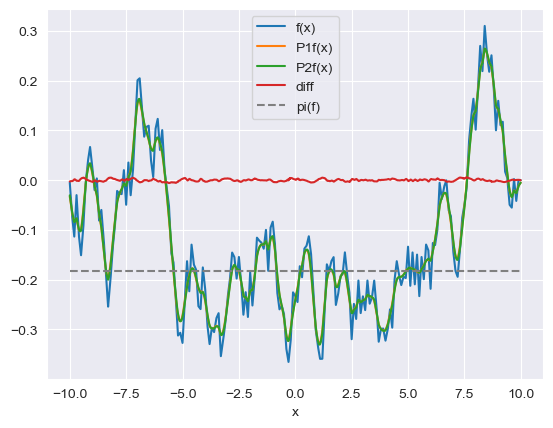

In [16]:
plt.plot(x, func(x), label="f(x)")
plt.plot(x, P1fx, label="P1f(x)")
plt.plot(x, P2fx, label="P2f(x)")
plt.plot(x, diff, label="diff")
plt.hlines(func(dist_samples).mean(), x.min(), x.max(), linestyles="--", color="gray", label="pi(f)")
plt.xlabel("x")
plt.legend()

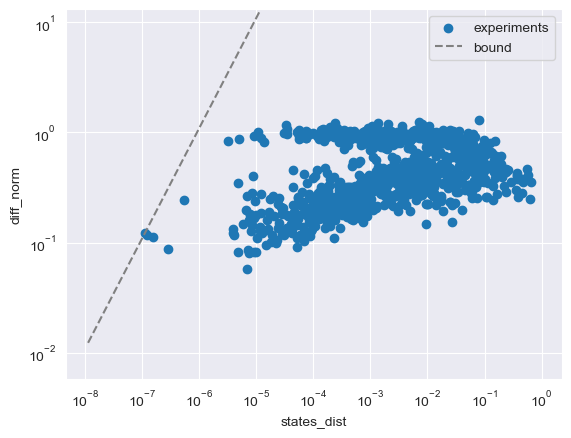

In [32]:
plt.scatter(d["states_dist"], d["diff_norm"], label="experiments")

dists = jnp.logspace(jnp.log10(d["states_dist"].min()) -1, jnp.log10(d["states_dist"].max()))
plt.plot(dists, L*dists, "--", color="gray", label="bound")

plt.ylabel("diff_norm")
plt.xlabel("states_dist")
plt.semilogx()
plt.semilogy()
plt.ylim(0.1*jnp.min(d["diff_norm"][d["diff_norm"] > 0]), 10 * jnp.max(d["diff_norm"]))
plt.legend()

# 2. Posteriordb

In [33]:
pdb_path = "../../posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

In [34]:
posterior = my_pdb.posterior("kidiq-kidscore_momhsiq")

p_model = posterior.model
p_data = posterior.data

In [35]:
data = {key: jnp.array(val) for key, val in posterior.data.values().items() if type(val) is list}
data_rest = {key: val for key, val in posterior.data.values().items() if type(val) is not list}

In [40]:
reference_draws_df = pd.concat([
    pd.DataFrame(chain_draw).assign(chain_id=i)
    for i, chain_draw in enumerate(posterior.reference_draws())
])
reference_draws_df.drop(columns=["chain_id"], inplace=True)

reference_draws = jnp.asarray(reference_draws_df)

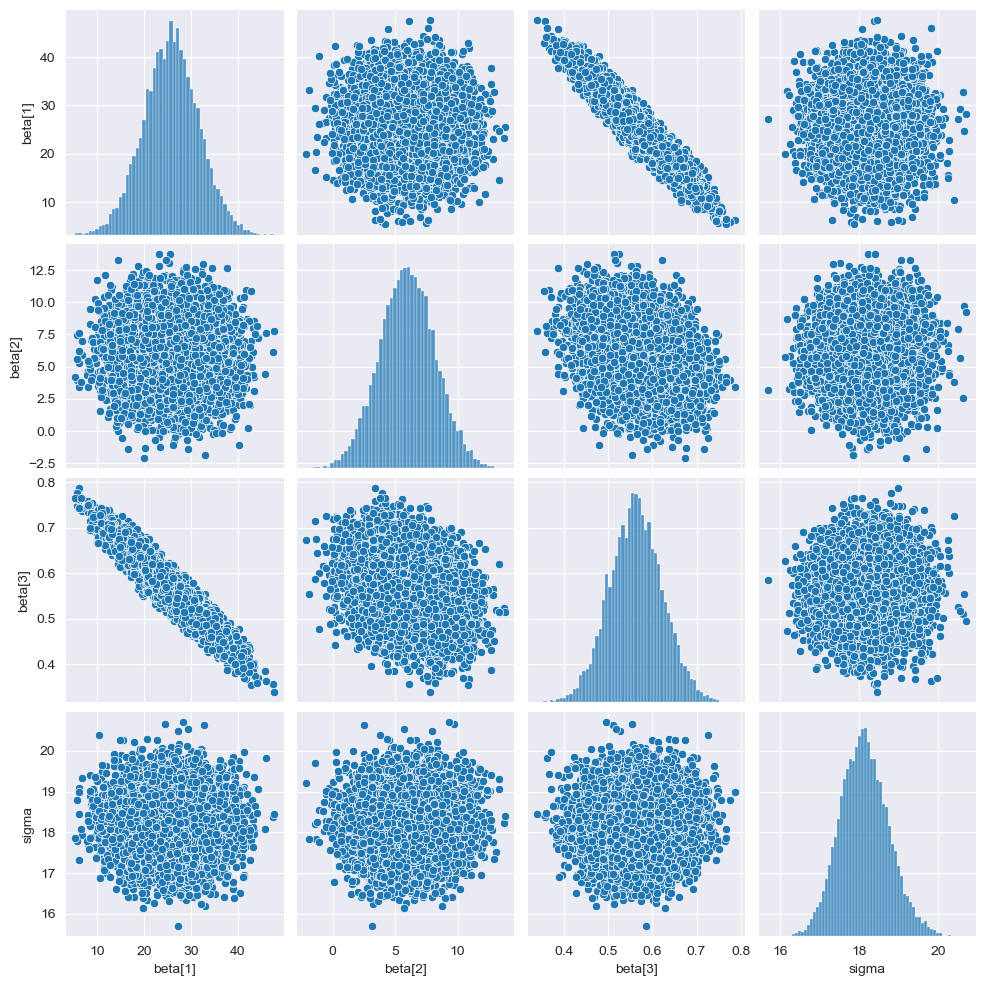

In [37]:
sns.pairplot(reference_draws_df)

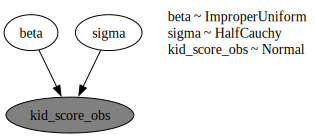

In [38]:
def model(mom_iq, mom_hs, kid_score=None):

    # Priors
    beta = numpyro.sample("beta", dist.ImproperUniform(dist.constraints.real_vector, (), event_shape=(3,)))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2.5))

    
    # Linear model
    ones = jnp.ones_like(mom_hs)
    X = jnp.stack([ones, mom_hs, mom_iq], axis=1)
    mu = jnp.matmul(X, beta)
    # mu = beta[0] + beta[1] * mom_hs + beta[2] * mom_iq

    # Observed variable
    numpyro.sample("kid_score_obs", dist.Normal(mu, sigma), obs=kid_score)

render_model(model, model_kwargs=data, render_distributions=True)

In [39]:
kernel = AMH(model)
rng_key = random.PRNGKey(0)

state = kernel.init(rng_key, num_warmup=0, init_params={}, model_args=(), model_kwargs=data)

In [67]:
s1 = sample_adapt_state(rng_key, dim=len(state.adapt_state.mean))
s2 = sample_neigbour(rng_key, state.adapt_state)

In [68]:
from jax.flatten_util import ravel_pytree

z_flat, unravel_fn = ravel_pytree(state.z)

In [69]:
state

AMHState(i=Array(0, dtype=int32, weak_type=True), z={'beta': Array([ 1.4896574 , -1.5557938 , -0.89167786], dtype=float32), 'sigma': Array(-0.88512325, dtype=float32)}, potential_energy=Array(40419724., dtype=float32), mean_accept_prob=Array(0., dtype=float32, weak_type=True), adapt_state=AMHAdaptState(mean=Array([ 1.4896574 , -1.5557938 , -0.89167786, -0.88512325], dtype=float32), covariance=Array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32), log_step_size=0.0), rng_key=Array([0, 0], dtype=uint32))

In [73]:
kernel._postprocess_fn()

functools.partial(<function transform_fn at 0x15e0e7d80>, {'beta': <numpyro.distributions.transforms.IndependentTransform object at 0x31da203b0>, 'sigma': <numpyro.distributions.transforms.ExpTransform object at 0x31da20350>})

In [59]:
state_ = AMHState(
    i=0,
    z=unravel_fn(z_flat),
    potential_energy=
)

TypeError: AMHState.__new__() missing 6 required positional arguments: 'i', 'z', 'potential_energy', 'mean_accept_prob', 'adapt_state', and 'rng_key'

In [64]:
reference_draws_df

,beta[1],beta[2],beta[3],sigma
0,43.315341,8.028461,0.374428,18.292501
1,23.388870,8.122381,0.551708,18.008244
2,23.518381,6.336248,0.592277,17.495827
3,26.799274,0.563804,0.599978,18.646986
4,26.779357,4.544044,0.556359,18.209594
...,...,...,...,...
995,26.776659,7.201880,0.534026,17.539622
996,25.078451,9.037136,0.543398,18.289046
997,27.018337,6.410937,0.546191,17.484793
998,21.825134,8.081853,0.582130,18.692422
